# Transfer Learning

                                     Valentyn Gerushta, Léane Salais 

Grâce au *transfer learning*, on peut réutiliser des poids déjà appris sur une base pour en faire profiter un autre modèle.


## Récupération du support 

In [ ]:
# Libraries 
import argparse
import os
import time
from timeit import default_timer as timer
from tqdm.auto import tqdm

import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import pickle

import torchvision
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms import functional
from torch.autograd import Variable

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [ ]:
# ImageNet labels 
!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl

--2021-01-15 15:11:20--  https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/imagenet_classes.pkl [following]
--2021-01-15 15:11:20--  https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: ‘imagenet_classes.pkl’

imagenet_classes.pk 100%[===================>]  34.62K  --.-KB/s    in 0s      

2021-01-15 15:11:21 (139 MB/s) - ‘imag

In [ ]:
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb')) # chargement des classes
imagenet_classes

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [ ]:
# Data
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

--2021-01-14 17:14:09--  https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true
Resolving unsplash.com (unsplash.com)... 151.101.129.181, 151.101.193.181, 151.101.1.181, ...
Connecting to unsplash.com (unsplash.com)|151.101.129.181|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&dl=manja-vitolic-gKXKBY-C-Dk-unsplash.jpg [following]
--2021-01-14 17:14:10--  https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&dl=manja-vitolic-gKXKBY-C-Dk-unsplash.jpg
Resolving images.unsplash.com (images.unsplash.com)... 151.101.10.208, 2a04:4e42:2::720
Connecting to images.unsplash.com (images.unsplash.com)|151.101.10.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1536117 (1.5M) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]   1.46M

## Architecture VGG16

VGG16 est un réseau à 16 couches déjà entraîné sur ImageNet. On va ici quantifier sa performance sur des images de test.

#### Composantes

In [ ]:
# Loading the model
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.eval()
# Showing its structure
vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Pour classer des images (et avoir juste un vecteur de scalaires en sortie), il faut qu'elles présentent le même format que celles d'ImageNet - ce qui implique recadrage et normalisation.

In [ ]:
# Data preprocessing // normalisation + resizing 
def preprocess(path):
  img = Image.open(path)
  img = img.resize((224, 224), Image.BILINEAR)
  img = np.array(img, dtype=np.float32) / 255
  img = img.transpose((2, 0, 1))
  img = np.expand_dims(img, 0) # batch prehension
  init = torch.Tensor(img)
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.255]
  return functional.normalize(init, mean, std, False) # (x - mean) / std

Fonction pour la prédiction.

In [ ]:
# Forward pass (no backprop)
def predict(path,model=vgg16,stop=False):
  x = preprocess(path)
  # Prediction  
  if stop: 
    # This is useful to get outputs from early stages.
    return model(x)
  else: 
    # Else, go down the full prediction path
    # Careful : torchvision models do not include the Softmax computation
    sm = torch.nn.Softmax(dim=1)
    y = sm(model(x))
    # Get all five best predictions 
    best5 = torch.topk(y,5)
    classes = best5[1].squeeze().tolist()
    probs = best5[0].squeeze().tolist()
    # Convert the output to a numpy array for easier computations 
    y = y.detach().cpu().numpy()
    print('\033[1mBest guess: I am {:.2f}% confident that this is a(n) {}\033[0m'.format(np.amax(y)*100, imagenet_classes[np.argmax(y)]))
    print('Other options: {} with probabilities {}'.format([imagenet_classes.get(c) for c in classes[1:]], probs[1:]))
    print('\033[92mReliability check: outputted probabilities sum to {}\033[0m\n'.format(np.sum(y)))
    return imagenet_classes[np.argmax(y)],np.amax(y)

#### Tâche de classification

Quantification des performances de VGG sur des exemples plus ou moins naturels.

In [ ]:
# Displaying the results 
def showPredict(path1,path2):
  im1 = Image.open(path1)
  im2 = Image.open(path2)
  fig = plt.figure(figsize=(12,7))
  ax1 = fig.add_subplot(121)
  plt.imshow(im1)
  plt.axis('off')
  ax2 = fig.add_subplot(122)
  plt.imshow(im2)
  plt.axis('off')
  plt.tight_layout()
  plt.show()
  predict(path1)
  predict(path2)

Images fournies 

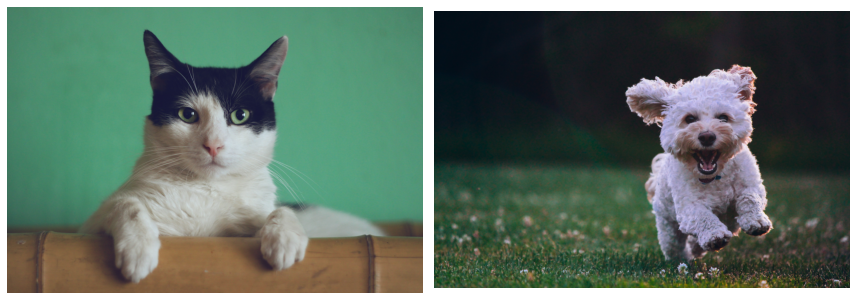

Best guess: I am 30.96% confident that this is a(n) Egyptian cat
Other options: ['carton', 'lynx, catamount', 'tabby, tabby cat', 'Siamese cat, Siamese'] with probabilities [0.16567163169384003, 0.13419146835803986, 0.08891940861940384, 0.04628457874059677]
Reliability check: outputted probabilities sum to 0.9999998211860657

Best guess: I am 20.77% confident that this is a(n) Lakeland terrier
Other options: ['miniature poodle', 'wire-haired fox terrier', 'Bedlington terrier', 'miniature schnauzer'] with probabilities [0.16839838027954102, 0.1576981097459793, 0.10698061436414719, 0.059180065989494324]
Reliability check: outputted probabilities sum to 1.0000001192092896



In [ ]:
showPredict("cat.jpg","dog.jpg")

Images type ImageNet

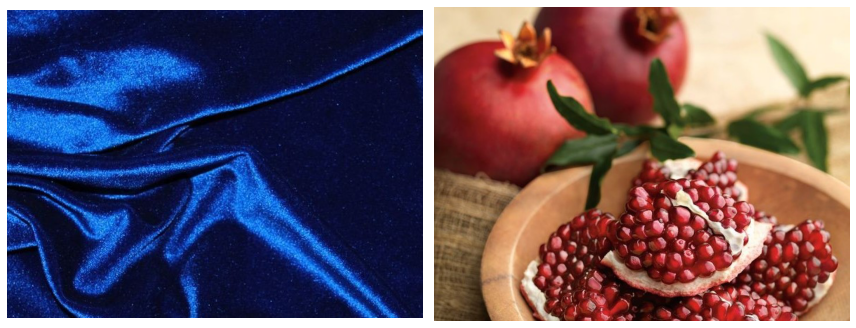

Best guess: I am 98.18% confident that this is a(n) velvet
Other options: ['mailbag, postbag', 'cloak', 'nematode, nematode worm, roundworm', 'bow tie, bow-tie, bowtie'] with probabilities [0.0014642892638221383, 0.0009420294663868845, 0.0007012445712462068, 0.0006525776698254049]
Reliability check: outputted probabilities sum to 1.0000001192092896

Best guess: I am 98.64% confident that this is a(n) pomegranate
Other options: ['banana', 'strawberry', 'fig', 'wooden spoon'] with probabilities [0.0032418142072856426, 0.0021888467017561197, 0.0021583710331469774, 0.0009041883749887347]
Reliability check: outputted probabilities sum to 0.9999999403953552



In [ ]:
showPredict('velvet.jpg','pomegranate.jpg')

Images moins ciblées (+ visages)

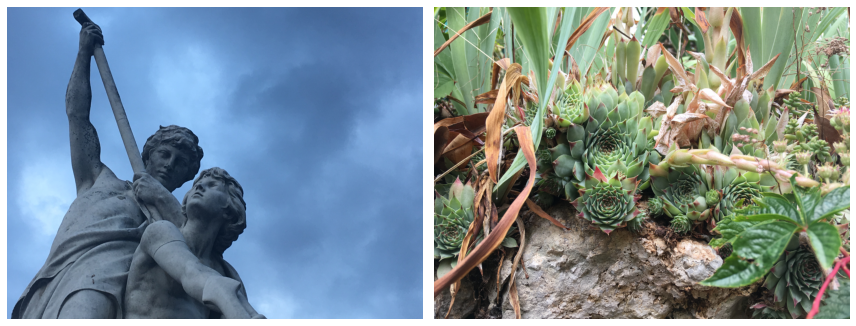

Best guess: I am 44.59% confident that this is a(n) pedestal, plinth, footstall
Other options: ['pole', 'flagpole, flagstaff', 'horizontal bar, high bar', 'chimpanzee, chimp, Pan troglodytes'] with probabilities [0.19710709154605865, 0.1457986980676651, 0.022843483835458755, 0.012732508592307568]
Reliability check: outputted probabilities sum to 1.0

Best guess: I am 18.42% confident that this is a(n) pot, flowerpot
Other options: ['greenhouse, nursery, glasshouse', 'walking stick, walkingstick, stick insect', 'African chameleon, Chamaeleo chamaeleon', "spider web, spider's web"] with probabilities [0.08629631996154785, 0.08442405611276627, 0.05102933198213577, 0.041513603180646896]
Reliability check: outputted probabilities sum to 1.0



In [ ]:
showPredict('statue.jpg','plant.jpg')

Eléments distinguables en arrière-plan 

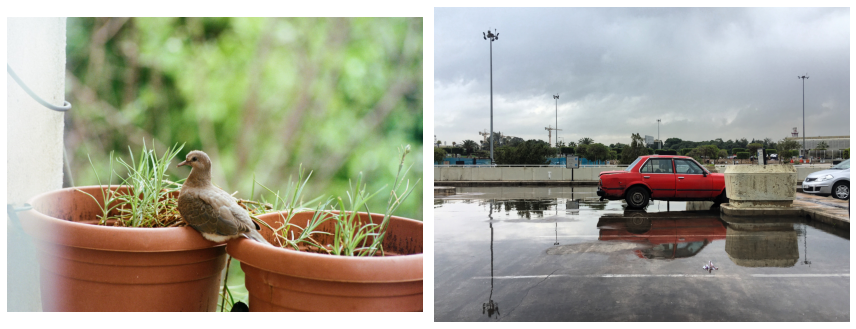

Best guess: I am 50.34% confident that this is a(n) quail
Other options: ['pot, flowerpot', 'milk can', 'bucket, pail', 'partridge'] with probabilities [0.21714316308498383, 0.04110242426395416, 0.03395077586174011, 0.03387729078531265]
Reliability check: outputted probabilities sum to 1.0

Best guess: I am 9.32% confident that this is a(n) minivan
Other options: ['tow truck, tow car, wrecker', 'snowplow, snowplough', 'dock, dockage, docking facility', 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi'] with probabilities [0.09127145260572433, 0.08591577410697937, 0.06541503220796585, 0.045069292187690735]
Reliability check: outputted probabilities sum to 1.0



In [ ]:
showPredict('bird.jpg','car.jpg')

Scènes complexes

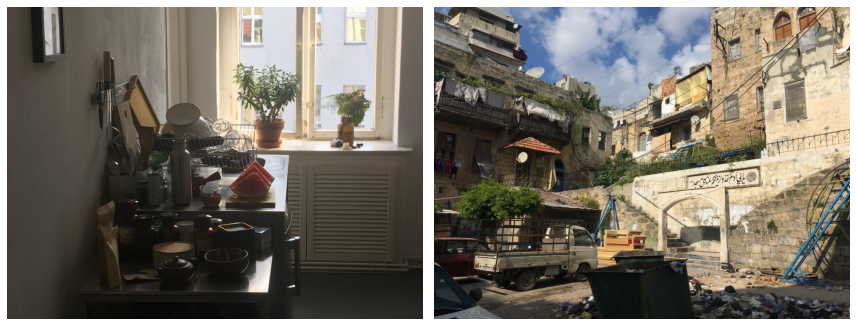

Best guess: I am 14.98% confident that this is a(n) dining table, board
Other options: ['sliding door', 'window shade', 'china cabinet, china closet', 'stove'] with probabilities [0.10483720898628235, 0.07768504321575165, 0.06746182590723038, 0.03269929438829422]
Reliability check: outputted probabilities sum to 1.0000001192092896

Best guess: I am 31.23% confident that this is a(n) castle
Other options: ['monastery', 'stupa, tope', 'palace', 'church, church building'] with probabilities [0.2362266629934311, 0.04765204340219498, 0.037003640085458755, 0.033626362681388855]
Reliability check: outputted probabilities sum to 1.0000001192092896



In [ ]:
showPredict('kitchen.jpg','city.jpg')

#### Récupération de cartes

On s'intéresse à la sortie de couches intermédiaires du réseau pour comprendre un peu le processus de décision. Par exemple, la première traite directement l'image d'entrée et son output devrait être plutôt lisible pour un humain : sur quoi les premiers filtres vont-ils se concentrer ?



In [ ]:
# Defining a single-layer model using VGG's conv1 weights
singlelayer = nn.Sequential(*list(vgg16.features.children())[:1])
for param in singlelayer.parameters():
    param.requires_grad = False

def getMap(path,model=singlelayer):
  outputs = predict(path,model,stop=True).squeeze()
  fig = plt.figure(figsize=(320,5))
  for i in range(64): #outputs.shape[0]): # on borne à 64 pour la simplicité 
    ax = fig.add_subplot(1, 64, i+1)
    plt.axis('off')
    plt.imshow(outputs[i])
    plt.gray()
    plt.colorbar()
    plt.tight_layout()
  plt.show()

On constate ci-dessous la variété des 64 filtres appris (ils sont tous différents) et aussi la similarité de traitement pour les deux images d'entrée.

In [ ]:
getMap("cat.jpg")
getMap("kitchen.jpg")
# cliquer sur les séries pour un affichage lisible

Output hidden; open in https://colab.research.google.com to view.

Plus d'expériences : prise en compte de la ReLU, et récupération de cartes beaucoup plus profondes.

In [ ]:
# Adding the ReLU
singlerelu = nn.Sequential(*list(vgg16.features.children())[:2])
for param in singlerelu.parameters():
    param.requires_grad = False

# Defining a twelve-layer model using VGG's weights
fivelayer = nn.Sequential(*list(vgg16.features.children())[:20])
for param in fivelayer.parameters():
    param.requires_grad = False

getMap("cat.jpg",model=singlerelu)
getMap("cat.jpg",model=fivelayer)
# cliquer sur les séries pour un affichage lisible

Output hidden; open in https://colab.research.google.com to view.

## Transfer Learning sur 15Scene

VGG16 a été entraîné sur ImageNet, mais les poids appris et donc les features extraites (notamment dans les premières couches de convolution) peuvent être récupérés pour classifier autre chose. Ici, on les essaie pour une reconnaissance de scènes.

#### Récupération du dataset

In [ ]:
!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!unzip 15ScenesData.zip

--2021-01-15 20:05:54--  https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/15ScenesData.zip [following]
--2021-01-15 20:05:54--  https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: ‘15ScenesData.zip’

15ScenesData.zip    100%[===================>]  82.51M   290MB/s    in 0.3s    

2021-01-15 20:05:55 (290 MB/s) - ‘15ScenesData

In [ ]:
PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):
    # Duplicating a B&W image's single channel to "convert" it to RGB encoding 
    # To be used with transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img
    #####################
    ## Votre code ici  ##
    #####################
    # Ajouter le pré-traitement
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([ 
            transforms.Lambda(duplicateChannel),
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.255])
        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([
            transforms.Lambda(duplicateChannel),
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.255])
        ]))
    ####################
    ##      FIN        #
    ####################
    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    return train_loader, val_loader

#### Création des modèles à SVM

On propose ici de créer plusieurs modèles inspirés de VGG16,
* complétés avec une SVM, 
* en maintenant ou non la partie classifier,
* en attaquant ou non la partie features.  

Ces modèles seront tous testés plus bas.

In [ ]:
# VGG16relu7 contains all of VGG16's layers, except for the very last one. 
# This output layer was used for the final classification and will be replaced with an SVM.
class VGG16relu7(nn.Module):
  def __init__(self):
    super(VGG16relu7, self).__init__() # recopier toute la partie convolutionnelle
    self.features = nn.Sequential(*list(vgg16.features.children()))
    # garder une partie du classifieur, -2 pour s'arrêter à relu7
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])
    
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0),-1)
    x = self.classifier(x)
    return x

VGG16relu7()

VGG16relu7(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [ ]:
# Deleting one more classification layer.
class VGG16relu6(nn.Module):
  def __init__(self):
    super(VGG16relu6, self).__init__()
    self.features = nn.Sequential(*list(vgg16.features.children()))
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-4])
    
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0),-1)
    x = self.classifier(x)
    return x

VGG16relu6()

VGG16relu6(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [ ]:
# No classification layers at all.
class VGG16noclass(nn.Module):
  def __init__(self):
    super(VGG16noclass, self).__init__()
    self.features = nn.Sequential(*list(vgg16.features.children()))
    
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0),-1)
    return x

VGG16noclass()

VGG16noclass(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [ ]:
# No classification layers. Also extracting less features
class VGG16lessfeat(nn.Module):
  def __init__(self,repool=False):
    super(VGG16lessfeat, self).__init__()
    full = list(vgg16.features.children())[:-7]
    if repool:
      full.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
    self.features = nn.Sequential(*full)
  
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0),-1)
    return x

VGG16lessfeat()

VGG16lessfeat(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [ ]:
translate = {VGG16relu7:'the required model',VGG16relu6:'a model with one less classification layer',VGG16noclass:'a version with no classifier', VGG16lessfeat:'a version with even less features'}

#### Procédure de test pour les SVM

Le paramétrage de `main()` sert à choisir le type de modèle, le type de noyau pour la SVM, la présence ou l'absence de PCA... Le test contient systématiquement un GridSearch manuel sur C.

In [ ]:
def extract_features(data,model,givensize):
    #####################
    ## Votre code ici  ##
    #####################
    # Initialising the features matrices
    # Adapting to whatever the final extracted features' shape is
    if not givensize: givensize = list(model.named_parameters())[-1][1].shape[0] # fonctionne exclusivement si classifier
    X = np.empty((0,givensize))
    y = np.empty((0))
    ####################
    ##      FIN        #
    ####################
    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0: print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA: input = input.cuda()
        #####################
        ## Votre code ici  ##
        #####################
        # Feature extraction à faire
        model.eval()
        output = model(Variable(input))
        x_feat = output.data.cpu().numpy()
        x_feat = x_feat / np.linalg.norm(x_feat,2,1,True) # Normalization L2
        X = np.append(X, x_feat, axis=0)
        y = np.append(y, target.numpy())
        ####################
        ##      FIN        #
        ####################    
    return X, y

def main(restype,args=[],path="15SceneData",batch_size=8,givensize=None,kernel=None,reduce=None):
    print('Instantiating '+translate[restype])
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer le modèle par un réseau tronqué pour faire de la feature extraction
    model = restype(*args)
    ####################
    ##      FIN        #
    #################### 
    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
    # On récupère les données
    print('Loading data...')
    train, test = get_dataset(batch_size, path)
    # Extraction des features
    startextraction = timer()
    print('\nTrain encoding (feature extraction)...')
    X_train, y_train = extract_features(train, model, givensize)
    print('\nTest encoding (feature extraction)...')
    X_test, y_test = extract_features(test, model, givensize)
    endextraction = timer()
    print('\nElapsed time: {}(s)'.format(endextraction-startextraction))
    #####################
    ## Votre code ici  ##
    #####################
    # Ajout d'une PCA
    if reduce:
      pca = PCA(n_components=reduce)
      pca.fit(X_train)
      print('Kept {} features'.format(pca.n_components_))
      X_train = pca.transform(X_train)
      X_test = pca.transform(X_test)
    # Apprentissage et évaluation des SVM
    print('\nSVM classification')
    startsvm = timer()
    # Mise en place d'un mécanisme de comparaison des C
    for C in [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
      if kernel: svm = SVC(C=C,kernel=kernel)
      else: svm = LinearSVC(C=C)
      svm.fit(X_train,y_train)
      accuracy = svm.score(X_test,y_test)
      print('\033[92mAccuracy = {} for C = {}\033[0m'.format(accuracy,C))
    endsvm = timer()
    print('\nElapsed time: {}(s)'.format(endsvm-startsvm))
    ####################
    ##      FIN        #
    ####################    

###### Modèle de base

In [ ]:
# Initial model
main(restype=VGG16relu7) # 4096 features at classifier input

Instantiating the required model
Loading data...

Train encoding (feature extraction)...
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188

Test encoding (feature extraction)...
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374

Elapsed time: 39.75707854500024(s)

SVM classification
Accuracy = 0.7949748743718593 for C = 0.0001
Accuracy = 0.8184254606365159 for C = 0.001
Accuracy = 0.8358458961474037 for C = 0.01
Accuracy = 0.8723618090452261 for C = 0.1
Accuracy = 0.8894472361809045 for C = 0.5
Accuracy = 0.8921273031825796 for C = 1
Accuracy = 0.8921273031825796 for C = 5
Accuracy = 0.8901172529313233 for C = 10

Elapsed time: 6.443094106999979(s)


###### Modification du type de kernel

Ci-dessous, on constate que les kernels non-linéaires étendent considérablement le temps d'exécution et n'impactent pas significativement la précision finale.

In [ ]:
# Other kernel
main(restype=VGG16relu7,kernel='rbf') # 4096 features at classifier input

Instantiating the required model
Loading data...

Train encoding (feature extraction)...
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188

Test encoding (feature extraction)...
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374

Elapsed time: 36.93825713899969(s)

SVM classification
Accuracy = 0.8532663316582915 for C = 0.0001
Accuracy = 0.8532663316582915 for C = 0.001
Accuracy = 0.8532663316582915 for C = 0.01
Accuracy = 0.8673366834170855 for C = 0.1
Accuracy = 0.8887772194304857 for C = 0.5
Accuracy = 0.8938023450586264 for C = 1
Accuracy = 0.8961474036850922 for C = 5
Accuracy = 0.8961474036850922 for C = 10

Elapsed time: 324.93636762200003(s)


In [ ]:
# Other kernel
main(restype=VGG16relu7,kernel='sigmoid') # 4096 features at classifier input

Instantiating the required model
Loading data...

Train encoding (feature extraction)...
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188

Test encoding (feature extraction)...
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374

Elapsed time: 36.12745305900171(s)

SVM classification
Accuracy = 0.8351758793969849 for C = 0.0001
Accuracy = 0.8351758793969849 for C = 0.001
Accuracy = 0.8351758793969849 for C = 0.01
Accuracy = 0.8525963149078727 for C = 0.1
Accuracy = 0.8874371859296483 for C = 0.5
Accuracy = 0.8911222780569514 for C = 1
Accuracy = 0.8860971524288107 for C = 5
Accuracy = 0.8743718592964824 for C = 10

Elapsed time: 292.35874650799997(s)


###### Ablation de couches FC

SCORE OPTIMAL SUR TOUTES LES EXPERIENCES OBTENU en en conservant une seule à la sortie des couches de convolution.

In [ ]:
# Deleting a FC layer: best score
main(restype=VGG16relu6) # 4096 features at classifier input

Instantiating a model with one less classification layer
Loading data...

Train encoding (feature extraction)...
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188

Test encoding (feature extraction)...
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374

Elapsed time: 39.804710433999844(s)

SVM classification
Accuracy = 0.8073701842546064 for C = 0.0001
Accuracy = 0.8358458961474037 for C = 0.001
Accuracy = 0.8499162479061977 for C = 0.01
Accuracy = 0.890787269681742 for C = 0.1
Accuracy = 0.9078726968174204 for C = 0.5
Accuracy = 0.9098827470686767 for C = 1
Accuracy = 0.9085427135678392 for C = 5
Accuracy = 0.9072026800670017 for C = 10

Elapsed time: 7.694555973999741(s)


In [ ]:
# Deleting all FC layers: SVC finds it a bit hard to follow (cf. elapsed time)
main(restype=VGG16noclass,givensize=25088) # 25088 features at classifier input

Instantiating a version with no classifier
Loading data...

Train encoding (feature extraction)...
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188

Test encoding (feature extraction)...
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374

Elapsed time: 68.50672255400013(s)

SVM classification
Accuracy = 0.8073701842546064 for C = 0.0001
Accuracy = 0.821105527638191 for C = 0.001
Accuracy = 0.84321608040201 for C = 0.01
Accuracy = 0.876716917922948 for C = 0.1
Accuracy = 0.8981574539363484 for C = 0.5
Accuracy = 0.9058626465661641 for C = 1
Accuracy = 0.9085427135678392 for C = 5
Accuracy = 0.9061976549413735 for C = 10

Elapsed time: 24.83590505200027(s)


###### Ablation de couches convolutionnelles supplémentaires

-- Avec ou sans max-pooling : il apparaît que le pooling est nécessaire pour que le classifieur puisse s'y retrouver (100352 vs. 25088 features) et pour conserver un temps de traitement tolérable.

In [ ]:
# Deleting FC layers + some conv layers, no max-pooling - bad idea
main(restype=VGG16lessfeat,givensize=100352) # 100352 features at classifier input

Instantiating a version with even less features
Loading data...

Train encoding (feature extraction)...
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188

Test encoding (feature extraction)...
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374

Elapsed time: 164.29279703300017(s)

SVM classification
Accuracy = 0.7175879396984924 for C = 0.0001
Accuracy = 0.7534338358458962 for C = 0.001
Accuracy = 0.7983249581239531 for C = 0.01
Accuracy = 0.8522613065326633 for C = 0.1
Accuracy = 0.8780569514237856 for C = 0.5
Accuracy = 0.8827470686767169 for C = 1
Accuracy = 0.8847571189279732 for C = 5
Accuracy = 0.8850921273031825 for C = 10

Elapsed time: 211.12237349400039(s)


In [ ]:
repool = True
# Deleting FC layers + some conv layers, with a max-pooling - slightly better
main(restype=VGG16lessfeat,args=[repool],givensize=25088) # 25088 features at the input thanks to MP

Instantiating a version with even less features
Loading data...

Train encoding (feature extraction)...
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188

Test encoding (feature extraction)...
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374

Elapsed time: 64.24451478599985(s)

SVM classification
Accuracy = 0.738358458961474 for C = 0.0001
Accuracy = 0.7634840871021775 for C = 0.001
Accuracy = 0.8023450586264657 for C = 0.01
Accuracy = 0.8592964824120602 for C = 0.1
Accuracy = 0.8931323283082077 for C = 0.5
Accuracy = 0.8971524288107202 for C = 1
Accuracy = 0.9011725293132329 for C = 5
Accuracy = 0.8998324958123953 for C = 10

Elapsed time: 88.79410473900134(s)


###### Ajout d'une PCA

Réduction du temps de traitement et du bruit pour la classification. Potentiel pour utiliser d'autres kernels. 

In [ ]:
# Improving the last score with a PCA // keeping 1256 features (see below)
repool = True
main(restype=VGG16lessfeat,givensize=25088,args=[repool],reduce=0.95)

Instantiating a version with even less features
Loading data...

Train encoding (feature extraction)...
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188

Test encoding (feature extraction)...
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374

Elapsed time: 59.72376328300015(s)
Kept 1256 features

SVM classification
Accuracy = 0.7557788944723618 for C = 0.0001
Accuracy = 0.7608040201005025 for C = 0.001
Accuracy = 0.8023450586264657 for C = 0.01
Accuracy = 0.8592964824120602 for C = 0.1
Accuracy = 0.8938023450586264 for C = 0.5
Accuracy = 0.8984924623115578 for C = 1
Accuracy = 0.8988274706867672 for C = 5
Accuracy = 0.8981574539363484 for C = 10

Elapsed time: 8.20504645100118(s)


In [ ]:
# Improving the BEST score with a PCA and a Gaussian SVC // keeping 851 features (see below)
main(restype=VGG16relu6,reduce=0.95,kernel='rbf')

Instantiating a model with one less classification layer
Loading data...

Train encoding (feature extraction)...
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188

Test encoding (feature extraction)...
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374

Elapsed time: 36.631752788000085(s)
Kept 851 features

SVM classification
Accuracy = 0.8730318257956449 for C = 0.0001
Accuracy = 0.8730318257956449 for C = 0.001
Accuracy = 0.8730318257956449 for C = 0.01
Accuracy = 0.8790619765494138 for C = 0.1
Accuracy = 0.9078726968174204 for C = 0.5
Accuracy = 0.9132328308207706 for C = 1
Accuracy = 0.9132328308207706 for C = 5
Accuracy = 0.9132328308207706 for C = 10

Elapsed time: 72.02873282200017(s)


In [ ]:
main(restype=VGG16relu6,reduce=0.95) 
# Non concluant

Instantiating a model with one less classification layer
Loading data...

Train encoding (feature extraction)...
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188

Test encoding (feature extraction)...
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374

Elapsed time: 36.19454993399995(s)
Kept 851 features

SVM classification
Accuracy = 0.83785594639866 for C = 0.0001
Accuracy = 0.840536013400335 for C = 0.001
Accuracy = 0.8505862646566165 for C = 0.01
Accuracy = 0.890787269681742 for C = 0.1
Accuracy = 0.9085427135678392 for C = 0.5
Accuracy = 0.9078726968174204 for C = 1
Accuracy = 0.9072026800670017 for C = 5
Accuracy = 0.904857621440536 for C = 10

Elapsed time: 4.9288503890002175(s)


In [ ]:
repool = True
main(restype=VGG16lessfeat,givensize=25088,args=[repool],reduce=0.95,kernel='rbf')
# Non concluant.

Instantiating a version with even less features
Loading data...

Train encoding (feature extraction)...
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188

Test encoding (feature extraction)...
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374

Elapsed time: 65.12433870699897(s)
Kept 1256 features

SVM classification
Accuracy = 0.80536013400335 for C = 0.0001
Accuracy = 0.80536013400335 for C = 0.001
Accuracy = 0.80536013400335 for C = 0.01
Accuracy = 0.80536013400335 for C = 0.1
Accuracy = 0.8278056951423786 for C = 0.5
Accuracy = 0.8485762144053601 for C = 1
Accuracy = 0.8549413735343384 for C = 5
Accuracy = 0.8549413735343384 for C = 10

Elapsed time: 126.29180740400079(s)


 #### Versions sans SVM

Il est aussi possible de compléter un VGG16 avec d'autres couches FC et de réentraîner le modèle obtenu (soit de rétropropager sur la dernière couche seule, soit sur la totalité). Voici les résultats - ils ne sont pas meilleurs.


In [ ]:
# Replacing VGG16's last FC layer with another that fits 15Scene's description.
class VGG16newFC(nn.Module):
  def __init__(self,freeze):
    super(VGG16newFC, self).__init__() 
    self.features = nn.Sequential(*list(vgg16.features.children()))
    full = list(vgg16.classifier.children())[:-1]
    # Replacing the last layer 
    full.append(nn.Linear(in_features=4096,out_features=15,bias=True))
    self.classifier = nn.Sequential(*full)
    # Freezing the weights if needed
    if freeze:
      for param in self.features.parameters():
        param.requires_grad = False
      for i,param in enumerate(list(self.classifier.parameters())[3::-1]):
        # Only the last layer will have its parameters (weight+bias) fine-tuned.
        param.requires_grad = False
      
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0),-1)
    x = self.classifier(x)
    return x

VGG16newFC(freeze=True)

VGG16newFC(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [ ]:
# Tip: ignoring the two last elements in a list 
l = [0,1,2,3,4,5]
for i,v in enumerate(l[3::-1]):
  print('Content',v)
  print('--Ranking',i)

Content 3
--Ranking 0
Content 2
--Ranking 1
Content 1
--Ranking 2
Content 0
--Ranking 3


In [ ]:
# Training loop.
def trainFCModel(backprop=False,epochs=10,lr=0.001,batch_size=8,path="15SceneData"):
  print('Instantiating a FC version')
  model = VGG16newFC(freeze=not(backprop))
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr)
  if CUDA: 
      cudnn.benchmark = True
      model = model.cuda()
      criterion = criterion.cuda()
  print('Loading data...')
  train, test = get_dataset(batch_size, path)

  for e in tqdm(range(epochs)):
      model.train()
      print('Training...')
      for i, (input, target) in enumerate(train):
        optimizer.zero_grad()
        if CUDA: 
          input = input.cuda()
          target = target.cuda()
        output = model(Variable(input))
        loss = criterion(output, target)
        loss.backward() 
        optimizer.step()

      model.eval()
      print('Evaluating...')
      accuracy = []
      for i, (input, target) in enumerate(test):
        if CUDA: 
          input = input.cuda()
          target = target.cuda()
        output = model(Variable(input))
        accuracy.append(sum((output.argmax(1) == target.reshape(-1))).item() / target.shape[0])
      print('Epoch {} accuracy = {}'.format(e, mean(accuracy)))
  
  print('\033[92mFinal test accuracy = {} for lr = {}\033[0m'.format(mean(accuracy),lr))

In [ ]:
trainFCModel()

Instantiating a FC version
Loading data...


Training...
Evaluating...
Epoch 0 accuracy = 0.4227941176470588
Training...
Evaluating...
Epoch 1 accuracy = 0.5955882352941176
Training...
Evaluating...
Epoch 2 accuracy = 0.6891711229946524
Training...
Evaluating...
Epoch 3 accuracy = 0.741644385026738
Training...
Evaluating...
Epoch 4 accuracy = 0.7723930481283422
Training...
Evaluating...
Epoch 5 accuracy = 0.8014705882352942
Training...
Evaluating...
Epoch 6 accuracy = 0.8188502673796791
Training...
Evaluating...
Epoch 7 accuracy = 0.829879679144385
Training...
Evaluating...
Epoch 8 accuracy = 0.8379010695187166
Training...
Evaluating...
Epoch 9 accuracy = 0.8462566844919787

Final test accuracy = 0.8462566844919787 for lr = 0.001


In [ ]:
trainFCModel(backprop=True)

Instantiating a FC version
Loading data...


Training...
Evaluating...
Epoch 0 accuracy = 0.3967245989304813
Training...
Evaluating...
Epoch 1 accuracy = 0.5822192513368984
Training...
Evaluating...
Epoch 2 accuracy = 0.6875
Training...
Evaluating...
Epoch 3 accuracy = 0.7439839572192514
Training...
Evaluating...
Epoch 4 accuracy = 0.7794117647058824
Training...
Evaluating...
Epoch 5 accuracy = 0.8008021390374331
Training...
Evaluating...
Epoch 6 accuracy = 0.8165106951871658
Training...
Evaluating...
Epoch 7 accuracy = 0.8262032085561497
Training...
Evaluating...
Epoch 8 accuracy = 0.8412433155080213
Training...
Evaluating...
Epoch 9 accuracy = 0.8455882352941176

Final test accuracy = 0.8455882352941176 for lr = 0.001


Comme les performances sont encore loin de celles des SVC, on décide d'allonger l'entraînement. Même après 50 epochs, l'accuracy ne semble plus beaucoup changer : les SVM avaient donc l'avantage d'aller plus loin et beaucoup plus vite.

In [ ]:
trainFCModel(epochs=50,lr=0.0005)

Instantiating a FC version
Loading data...


Training...
Evaluating...
Epoch 0 accuracy = 0.42780748663101603
Training...
Evaluating...
Epoch 1 accuracy = 0.588903743315508
Training...
Evaluating...
Epoch 2 accuracy = 0.6875
Training...
Evaluating...
Epoch 3 accuracy = 0.7406417112299465
Training...
Evaluating...
Epoch 4 accuracy = 0.7767379679144385
Training...
Evaluating...
Epoch 5 accuracy = 0.7997994652406417
Training...
Evaluating...
Epoch 6 accuracy = 0.8255347593582888
Training...
Evaluating...
Epoch 7 accuracy = 0.8355614973262032
Training...
Evaluating...
Epoch 8 accuracy = 0.8442513368983957
Training...
Evaluating...
Epoch 9 accuracy = 0.8495989304812834
Training...
Evaluating...
Epoch 10 accuracy = 0.8546122994652406
Training...
Evaluating...
Epoch 11 accuracy = 0.8596256684491979
Training...
Evaluating...
Epoch 12 accuracy = 0.8626336898395722
Training...
Evaluating...
Epoch 13 accuracy = 0.8669786096256684
Training...
Evaluating...
Epoch 14 accuracy = 0.8683155080213903
Training...
Evaluating...
Epoch 15 accuracy = 0

In [ ]:
trainFCModel(backprop=True,epochs=50,lr=0.0005)

Instantiating a FC version
Loading data...


Training...
Evaluating...
Epoch 0 accuracy = 0.45688502673796794
Training...
Evaluating...
Epoch 1 accuracy = 0.5892379679144385
Training...
Evaluating...
Epoch 2 accuracy = 0.6921791443850267
Training...
Evaluating...
Epoch 3 accuracy = 0.75
Training...
Evaluating...
Epoch 4 accuracy = 0.7850935828877005
Training...
Evaluating...
Epoch 5 accuracy = 0.8101604278074866
Training...
Evaluating...
Epoch 6 accuracy = 0.8255347593582888
Training...
Evaluating...
Epoch 7 accuracy = 0.8382352941176471
Training...
Evaluating...
Epoch 8 accuracy = 0.8425802139037433
Training...
Evaluating...
Epoch 9 accuracy = 0.8492647058823529
Training...
Evaluating...
Epoch 10 accuracy = 0.8495989304812834
Training...
Evaluating...
Epoch 11 accuracy = 0.8579545454545454
Training...
Evaluating...
Epoch 12 accuracy = 0.8629679144385026
Training...
Evaluating...
Epoch 13 accuracy = 0.8676470588235294
Training...
Evaluating...
Epoch 14 accuracy = 0.8686497326203209
Training...
Evaluating...
Epoch 15 accuracy = 0.